In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVR, LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [44]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 666.3 kB/s eta 0:00:00m eta 0:00:0136m0:00:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:04m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
dataCount = 0
junkCount = 0
jsonMap = json.load(open('flowMap.json'))
for root, _, files in os.walk('features/Type3/0_02'):
    for f in files:
        if f.endswith('.csv'):
            try:
                df = pd.read_csv(os.path.join(root, f))
                filePath = os.path.join(root, f)
                key = '_'.join(filePath.split('_')[:-1]) + '.pcap'
                key = 'pcap_dataset/'+'/'.join(key.split('/')[1:])
                if int(jsonMap[key]/1000) != int(list(df['input_flows'])[-1]/1000):
                    dataCount += 1
                    print(os.path.join(root, f))
                    os.remove(os.path.join(root,f))
            except pd.errors.EmptyDataError:
                #os.remove(os.path.join(root,f))
                print('CSV file is empty')
            except FileNotFoundError:
                print('CSV file not found')
print(dataCount) 


features/Type3/0_02/_00173_20180315125958_0_4.csv
features/Type3/0_02/_00173_20180315125958_2_1.csv
features/Type3/0_02/_00173_20180315125958_2_3.csv
features/Type3/0_02/_00173_20180315125958_4_4.csv
4


In [9]:
# Paths to the benign and attack directories

from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as xgb

benign_path = "features/Type3/0_01"
attack_path = "features/Type3/0_03"

# Function to load data and assign labels
def load_data_from_folder(folder_path, label):
    data = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, file))
                try:
                    df.drop(columns=['Poll_Num', 'Time_Window'], inplace=True)
                except:
                    continue
                if len(df) == 0:
                    continue
                if len(df) < 28:
                    last_row = df.iloc[-1]
                    padding_rows = 28 - len(df)
                    padded_df = pd.DataFrame([last_row] * padding_rows, columns=df.columns)
                    # Concatenate the original DataFrame with the padded DataFrame
                    #df = pd.DataFrame(normalize(df, norm='l2'), columns=df.columns)
                    df = pd.concat([df, padded_df], ignore_index=True)
                
                flattened = df[:28].to_numpy().flatten()
                # Flatten the 28 rows into a single 1D array
                data.append((flattened, label))  # Append data with label
    return data

# Load benign and attack data

benign_data = load_data_from_folder(benign_path, 0)
attack_data = load_data_from_folder(attack_path, 1)

print("Length of Benign Dataset", len(benign_data))
print("Length of Attack Dataset", len(attack_data))

import random
# Combine and create DataFrame
all_data = benign_data + attack_data
random.shuffle(all_data)
X = pd.DataFrame([item[0] for item in all_data])  # Feature matrix
y = pd.Series([item[1] for item in all_data])

# Labels
scaler = MinMaxScaler()
X_transformed = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
#Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt

pairs = [str((i, j)) for i in range(28) for j in range(8)]
plt.figure(figsize=(200, 200))
plot_tree(model, feature_names=pairs, class_names=['Benign', 'Attack'], filled=True)
plt.show()
#print("Coefficients:",model.coef_)
#print("Intercept:",model.intercept_)


Length of Benign Dataset 7185
Length of Attack Dataset 7184
Accuracy: 0.7599164926931107
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       725
           1       0.75      0.77      0.76       712

    accuracy                           0.76      1437
   macro avg       0.76      0.76      0.76      1437
weighted avg       0.76      0.76      0.76      1437



KeyboardInterrupt: 

In [12]:
import pandas as pd
df1 = pd.read_csv('features/Type1/0_01/_00000_20180315125910_0_1.csv')
df2 = pd.read_csv('features/Type1/0_03/_00000_20180315125910_0_1.csv')
df3 = pd.read_csv('features/Type1/0_05/_00000_20180315125910_0_1.csv')
df4 = pd.read_csv('features/Type1/0_07/_00000_20180315125910_0_1.csv')
df5 = pd.read_csv('features/Type1/0_1/_00000_20180315125910_0_1.csv')
cols = df1.columns

In [3]:
cols

Index(['Poll_Num', 'Time_Window', 'Pkt_Count', 'input_flows',
       'completely_colliding_flows', 'non_colliding_flows',
       'cells_occupied_epochend', 'purecell_count_before_decode',
       'purecell_all_collision', 'collisions_by_allflows'],
      dtype='object')

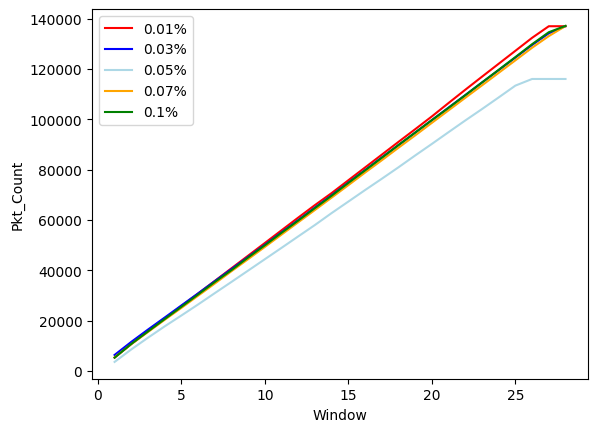

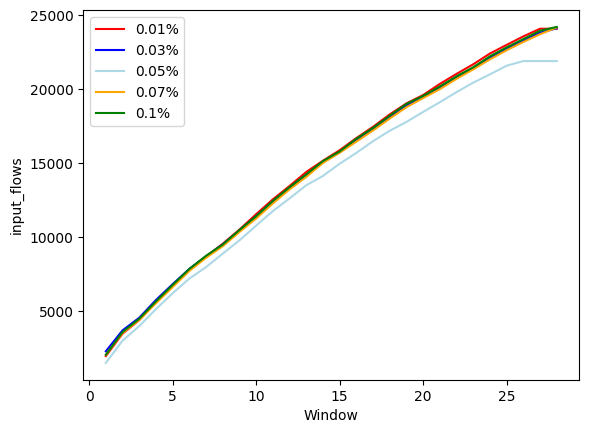

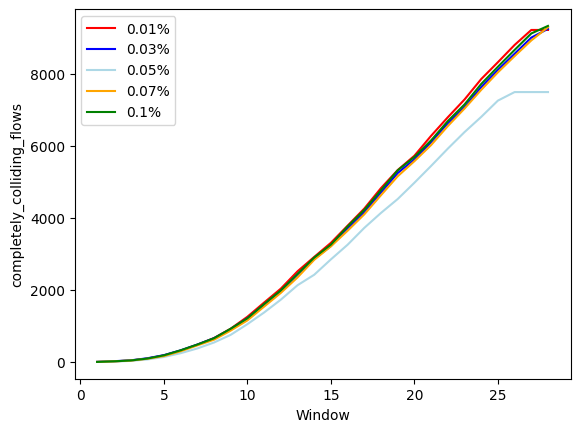

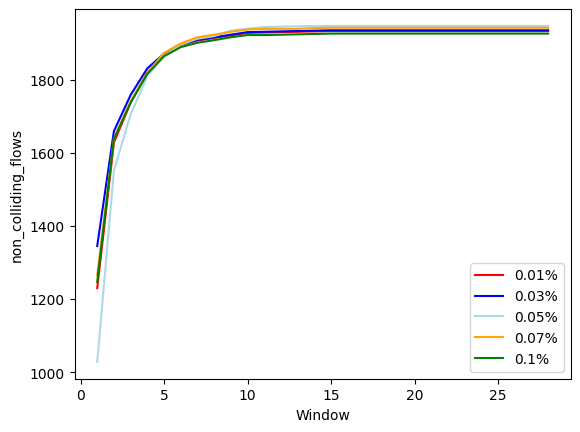

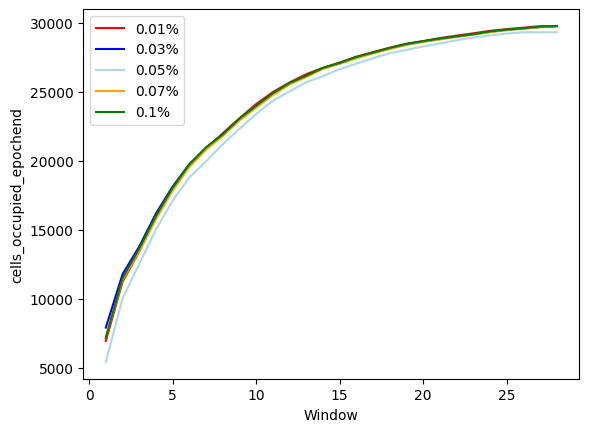

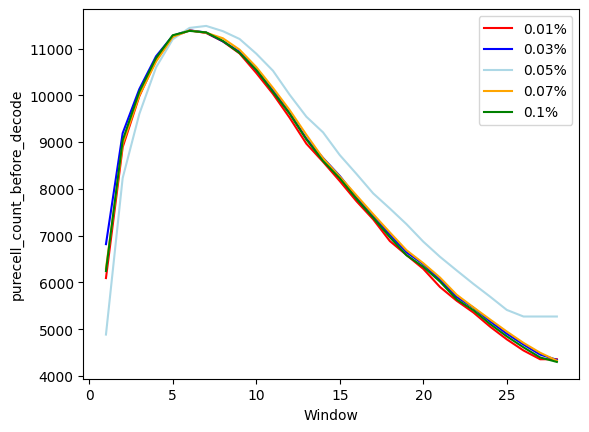

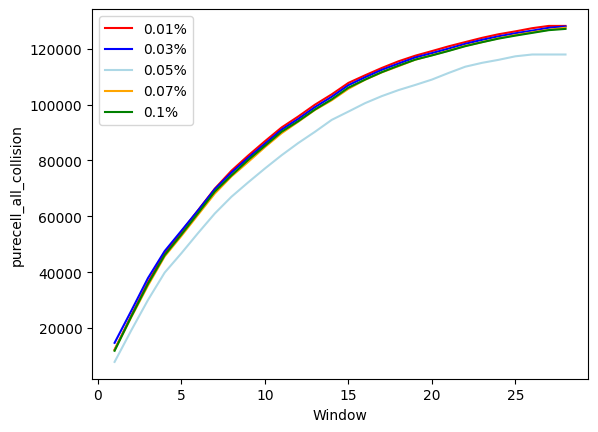

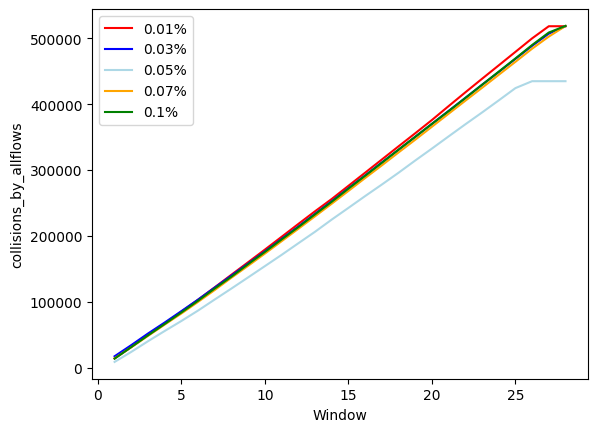

In [13]:
X = list(df1['Time_Window'])
Y_labels = list(cols[2:])
import matplotlib.pyplot as plt

for lbl in Y_labels:
    plt.plot(X, df1[lbl], color = 'red', label = '0.01%')
    plt.plot(X, df2[lbl], color = 'blue', label = '0.03%')
    plt.plot(X, df3[lbl], color = 'lightblue', label = '0.05%')
    plt.plot(X, df4[lbl], color = 'orange', label = '0.07%')
    plt.plot(X, df5[lbl], color = 'green', label = '0.1%')
    plt.xlabel('Window')
    plt.ylabel(lbl)
    plt.legend()
    plt.show()    
